In this notebook we estimate **heterogeneous treatment effects (HTEs)**  
using **CausalForestDML** from `econml`.

Our goals:

1. Fit a causal forest using the cleaned dataset `df_ps`
2. Estimate the Conditional Average Treatment Effect (CATE) for each order
3. Explore uplift distribution
4. Identify customer segments with particularly high or low uplift

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib



In [2]:
df = pd.read_csv("../data/processed/model_df_with_ps.csv")
df.head(1)

,late_delivery,review_score,order_purchase_dayofweek,order_purchase_hour,estimated_delivery_days,price,freight_value,product_volume_cm3,payment_value,payment_type,customer_state,customer_city,seller_state,seller_city,product_category_name,ps_logit,ps_gb,ipw,ipw_stabilized
0,0,4.0,0,10,15,29.99,8.72,1976.0,38.71,credit_card,SP,sao paulo,SP,maua,utilidades_domesticas,0.045035,0.042196,1.047159,0.967589


In [3]:
T = df["late_delivery"].astype(int).values

# Outcome
Y = df["review_score"].astype(float).values

# Features
X = df.drop(columns=["late_delivery", "review_score"])

drop_cols = ["customer_city", "seller_city"]
X_small = X.drop(columns=[c for c in drop_cols if c in X.columns])

num_cols = X_small.select_dtypes(include=[float, int]).columns.tolist()
cat_cols = X_small.select_dtypes(include=["object"]).columns.tolist()

preprocess_cf = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="mean"), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

preprocess_cf.fit(X_small)
X_enc = preprocess_cf.transform(X_small)
if hasattr(X_enc, "toarray"):
    X_enc = X_enc.toarray()

## fit causal forest

In [4]:
rf_ns = RandomForestRegressor(
    n_estimators=40,
    max_depth=6,
    random_state=9527
)

causal_forest = CausalForestDML(
    model_t=rf_ns,
    model_y=rf_ns,
    
    n_estimators=100,         # reduced
    max_depth=10,            # prevents massive trees
    min_samples_leaf=60,     # stabilizes & speeds up
    max_samples=0.5,         # faster sampling
    random_state=9527,
    verbose=1
)

causal_forest.fit(
    Y=Y, T=T, X=X_enc
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


## estimate CATE

In [5]:
tau_hat = causal_forest.effect(X_enc)

df["tau_hat"] = tau_hat
df["tau_rank"] = df["tau_hat"].rank(pct=True)
df[["tau_hat", "tau_rank"]].head()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


,tau_hat,tau_rank
0,0.814740,0.521504
1,-5.156659,0.165523
2,5.734148,0.840227
3,16.624836,0.981376
4,1.866033,0.594195


In [9]:
df.to_csv("../data/processed/model_df_with_ps_tau.csv", index=False)

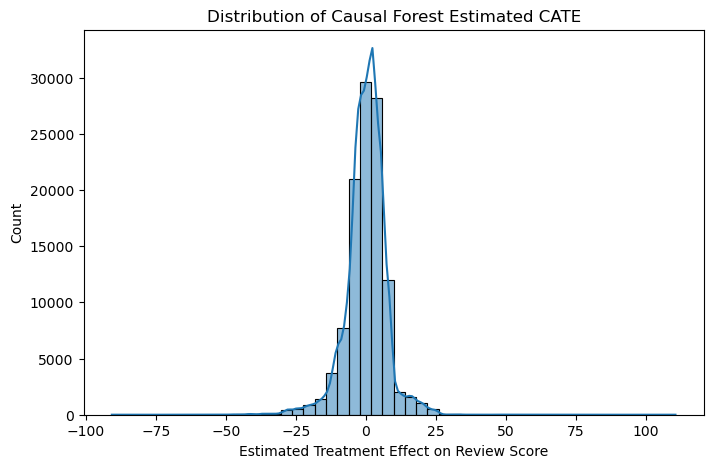

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df["tau_hat"], bins=50, kde=True)
plt.title("Distribution of Causal Forest Estimated CATE")
plt.xlabel("Estimated Treatment Effect on Review Score")
plt.show()

## Inspect extreme groups (Top & Bottom 10%)

In [7]:
hi = df[df["tau_rank"] > 0.9]
lo = df[df["tau_rank"] < 0.1]

print("Top 10% uplift mean:", hi["tau_hat"].mean())
print("Bottom 10% uplift mean:", lo["tau_hat"].mean())

Top 10% uplift mean: 11.993935593119128
Bottom 10% uplift mean: -13.795103031908404
